# Custom Environment: Intermediate Haunted Mansion
------

Building on top of the simple environment by adding in ghosts and candies, in addition to a penalty for each timestep the agent is not at its target location.

Rules of the environemnt are the same with some modifications:

    - There are 4 discrete actions the agent can take: up. down, left and right
    - The game terminates when the agent has reached the exit door of the haunted mansion
    - The agent represents the trick-or-treater
    - The agent receives a reward of + 10 when they have reached the exit door
    - For each timestep where the agent is not at the target location, they receive a penalty of - 0.1
    - If the agent encounters a ghost along their path they receive a penalty of -5, if they encounter a candy they recieve reward of +5

## Set Up
-----

In [12]:
import numpy as np
import gymnasium as gym
import pygame
import sys
import matplotlib.pyplot as plt

## Defining Custom Environment
----

In [4]:
class Intm_Haunted_Mansion(gym.Env):

    # Defining metadata (render_modes/render_fps)
    metadata = {'render_modes' : ['human'], 'render_fps': 1}

    ##########################################################################
    # Init
    ##########################################################################

    def __init__(self, size: int = 5, render_mode = 'human'):
        ''' 
        Description:
            Initialises the environment

        Inputs:
            size: int 
                The grid size, 5 by 5 for default 

            render_mode: str
                For visualisation, default render mode set to 'human'

        Outputs:
            size : int
                The size of the grid, which will be a square of `size x size`.
                
            render_mode : str
                The rendering mode used by the environment.
                
            num_rows : int
                Number of rows in the grid, equal to `size`.
                
            num_cols : int
                Number of columns in the grid, equal to `size`.
                
            agent_location : array
                Initial location of the agent as a numpy array.
                
            target_location : array
                Fixed location of the target/door as a numpy array, set to [4, 4].
                
            observation_space : gym.spaces.Dict
                Observation space for the environment, containing the agent's and target's grid positions.
                
            action_space : gym.spaces.Discrete
                Action space with four discrete actions: right, up, left, down.
                
            action_to_direction : dict
                Dictionary that maps actions.
                
            screen_size : int 
                The pixel size of the screen for displaying the grid; defaults to 800.
                
            cell_size : int 
                The pixel size of each cell in the grid.
        '''

        # Setting size of grid to size input parameter
        self.size = size   

        # Setting render mode to render_mode input parameter    
        self.render_mode = render_mode

        # Setting number of rows and columns of grid using size
        self.num_rows, self.num_cols = self.size, self.size

        # Placeholder value for agent location, the agent is out of bounds and is randomly set on the grid during reset() function
        self.agent_location = np.array([-1, -1], dtype=np.int64)   

        # Setting position of the target_location (exit door), the door is static
        self.target_location = np.array([4, 4], dtype=np.int64)

        # Setting position of the target_location (exit door), the door is static
        self.ghosts_location = np.array([[0, 0],[3, 2],[2, 4]])
        
        # Setting position of the target_location (exit door), the door is static
        self.candies_location = np.array([[2, 2],[0, 3]])


        # Observations are represented as dictionaries with the agent's and the target's location.
        self.observation_space = gym.spaces.Dict(
            {
                'agent': gym.spaces.Box(0, size - 1, shape=(2,), dtype = np.int64), # 1d array 2 elements
                'target': gym.spaces.Box(0, size - 1, shape=(2,), dtype = np.int64),
                'ghosts': gym.spaces.Box(0, size - 1, shape=(self.ghosts_location.shape[0], 2), dtype = np.int64), #2d array of 3,2
                'candies': gym.spaces.Box(0, size - 1, shape=(self.candies_location.shape[0], 2), dtype = np.int64)
            }
        )

        # We have 4 actions: right, up, left, down
        self.action_space = gym.spaces.Discrete(4)

        # Dictionary to map the actions to directions on the grid
        self.action_to_direction = {            
            0: np.array([1, 0]),  # right
            1: np.array([0, 1]),  # up
            2: np.array([-1, 0]),  # left
            3: np.array([0, -1]),  # down
        }
        
        # Initialise Pygame if render_mode is 'human'
        
        if self.render_mode == 'human':
            pygame.init()
            self.screen_size = 800
            self.cell_size = self.screen_size // self.size
            self.screen = pygame.display.set_mode((self.screen_size, self.screen_size))

            pygame.display.set_caption('Trick or ReTreat: Escape the Mansion!')


    ##########################################################################
    # Returning Observations
    ##########################################################################

    def _get_obs(self):
        ''' 
        Description:
            Returns environment observations based on agents location. 

        Outputs:
            observations: dict
                Returns agent's and target's location.
        '''
        observation = {
            'agent': self.agent_location, 
            'target': self.target_location, 
            'ghosts': self.ghosts_location,
            'candies': self.candies_location
        }
        
        return observation


    ##########################################################################
    # Returning Distance (between the agent and door)
    ##########################################################################

    def _get_info(self):
        ''' 
        Description:
            Returns environment information based on agents location (door). 

        Outputs:
            information: 
                Returns distance between agent and target location (door).
        '''
        return {
            'distance': np.linalg.norm(
                self.agent_location - self.target_location, ord=1
            )
        }

    ##########################################################################
    # Resetting the Environment
    ##########################################################################

    def reset(self, seed:int = None, options: dict = None):
        ''' 
        Description:
            Resets environment to an initial state.

        Inputs:
            seed: int 
                Control randomness, set to None as default.

        Outputs:
            information: 
                Returns initial observation and info of environmend based on agent's starting location
        '''
        # We need the following line to seed self.np_random
        super().reset(seed=seed, options=options)

        # Setting the agents starting location randomly on the grid
        self.agent_location = self.np_random.integers(0, self.size, size=2, dtype= np.int64)
        self.candies_location = np.array([[2, 2], [0, 3]])
        
        # Getting initial observations and info based on starting agent position
        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == 'human':
            self.render()
        
        return observation, info

    ##########################################################################
    # Step
    ##########################################################################  
    
    def step(self, action):

        ''' 
        Description:
            To get observation, reward, terminated, truncated and info once agent has taken an action.

        Inputs:
            action: int 
                Control randomness, set to None as default.

        Outputs:
            observation:
                Returns observation (agent, target location) of environment based on action agent has taken.

            reward:
                Points received when agent reaches the target.
            
            terminated:
                Boolean flag, set to True only if the the agent reaches the target(door).

            truncated:
                Boolean flag, set to False always (simple environment).

            info:
                Returns info of environment based on action agent has taken.
        '''

        # Converting action to int
        if isinstance(action, np.ndarray):
            action = np.int64(action.item()) 

        direction = self.action_to_direction[action]

        # We use np.clip to make sure we don't leave the grid bounds
        self.agent_location = np.clip(
            self.agent_location + direction, 0, self.size - 1
        )

        truncated = False

        # Terminated only when reward is reached (agent same location as door)
        terminated =np.array_equal(self.agent_location, self.target_location)

        # Initialising reward to 0
        reward = 0
        
        if terminated:
            reward += 20
        else:
            # Check if the agent encounters a ghost
            if any(np.array_equal(self.agent_location, ghost) for ghost in self.ghosts_location):
                reward -= 5  # Penalty for encountering ghosts
            
            for candy in self.candies_location:
                if not np.array_equal(candy, [-1, -1]) and np.array_equal(self.agent_location, candy):
                    reward += 5  # Reward for collecting candy
                    candy[:] = [-1, -1]  # Mark the candy as collected by setting it to [-1, -1]
                            
            reward -= 0.2 # Dont want to be too high that it discourages exploring! 

        # Get observation and info after taking an action
        observation = self._get_obs()
        info = self._get_info()

        return observation, reward, terminated, truncated, info

    ##########################################################################
    # Render
    ##########################################################################  
   
    def render(self):
        ''' 
        Description:
            To visualise the environment and agent's actions, only rendering mode is for human.

        Outputs:
            pygame display window depicting grid, agent's movement and target location.
        '''
                
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                sys.exit()

        # Set background to all white
        self.screen.fill((255, 255, 255))

        # Looping through rows and columns to draw rectanges (representing the grid)
        for row in range(self.size):
            for col in range(self.size):
                # Calculates x and y positions of each cell in the grid by multiplying the col/row index by pixel cell size
                cell_x = col * self.cell_size
                cell_y = row * self.cell_size
                # Drawing white rectangle to represent each cell in the grid
                pygame.draw.rect(self.screen, (0, 0, 0), (cell_x, cell_y, self.cell_size, self.cell_size), 1)

        # To calculate the offset to ensure images are placed in centre of cells
        offset = self.cell_size * 0.1

        # Transform target grid cooridinates into pixel coordinates 
        door_pos = self.target_location * self.cell_size
        
        # Representing the door as an image from Canva
        door_img = pygame.image.load('images/Door.png')
        # Scaling the image of the Door to be smaller than size of the cell
        door_img = pygame.transform.scale(door_img,(self.cell_size * 0.8,self.cell_size * 0.8))
        # Drawing the image to the grid, adding offset to ensure img is in the middle
        self.screen.blit(door_img, (door_pos[1] + offset , door_pos[0] + offset))

        for ghost in self.ghosts_location:
            # Calculate the position of the ghost in terms of pixels
            ghost_pos = ghost * self.cell_size
            # Load the image of the ghost
            ghost_img = pygame.image.load('images/Ghost.png')
            # Scale the image to fit within the cell
            ghost_img = pygame.transform.scale(ghost_img, (self.cell_size * 0.8, self.cell_size * 0.8))
            # Add offset to center the image in the cell and render it at the calculated position
            self.screen.blit(ghost_img, (ghost_pos[1] + offset, ghost_pos[0] + offset))
        
        for candy in self.candies_location:
            # Calculate the position of the ghost in terms of pixels
            candy_pos = candy * self.cell_size
            # Load the image of the ghost
            candy_img = pygame.image.load('images/Candy.png')
            # Scale the image to fit within the cell
            candy_img = pygame.transform.scale(candy_img, (self.cell_size * 0.8, self.cell_size * 0.8))
            # Add offset to center the image in the cell and render it at the calculated position
            self.screen.blit(candy_img, (candy_pos[1] + offset, candy_pos[0] + offset))

        agent_pos = self.agent_location * self.cell_size
        # Representing the agent as an image from Canva
        agent_img = pygame.image.load('images/Agent.png')
        agent_img = pygame.transform.scale(agent_img,(self.cell_size * 0.8,self.cell_size * 0.8))
        self.screen.blit(agent_img, (agent_pos[1] + offset, agent_pos[0] + offset))

        # To keep updating the display after each action
        pygame.display.update()  

    ##########################################################################
    # Close
    ##########################################################################  

    def close(self):
        ''' 
        Description:
            To close environment.

        Outputs:
            Quit all pygame windows after the environment is no longer in use.
        '''
        
        if self.render_mode == 'human':
            pygame.quit()  # Close the pygame window

In [5]:
# Register the environment
gym.register(
    id='Haunted_Mansion-v2',
    entry_point = '__main__:Intm_Haunted_Mansion'  
)

In [6]:
# Make the custom env, set the render_mode to huamn
env = gym.make('Haunted_Mansion-v2',  render_mode='human')

## Quick Rendering Test with Random Actions
---

In [6]:
# Resetting the environment, to set the agent to a random starting place on the grid
env.reset()
score = 0
# Run the environment for 50 random steps
for i in range(50):

    # Using sample() to pick random action for agent to take
    action = env.action_space.sample()
    # Calling step to get information on env after action takes the random action
    obs, reward, terminated, truncated, info = env.step(action)

    env.render()
    
    # Add time delay in pygame to pause after each action, allows for better viewing
    pygame.time.delay(350)
    score =+ reward

    # If the agent has reached the target, break out of the loop and end the episode
    if terminated:
        break

# Close the environment
env.close()

## Training with PPO
---

In [7]:
# Importing stable baselines 3 for PPO and Wrappers
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.vec_env import VecMonitor

In [8]:
# Register the environment
gym.register(
    id='Haunted_Mansion-v2',
    entry_point = '__main__:Intm_Haunted_Mansion'  
)

/Users/simybasra/anaconda3/envs/trick_or_retreat/lib/python3.9/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment Haunted_Mansion-v2 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [9]:
log_path = ('../../Training/Logs/')

In [10]:
# Create the environment and vectorise it using DummyVecEnv
v_env = DummyVecEnv([lambda: gym.make('Haunted_Mansion-v2', render_mode = None) for i in range(3)])
learn_env = VecMonitor(v_env,filename=log_path) # using vec monitor since have multiuple environments

In [11]:
# Initialise PPO model
# Having to use MultiInputPolicy instead of MlpPolicy since observations are of type dict
model = PPO('MultiInputPolicy', learn_env, verbose=1)

# Train the agent for 100_000 time steps
model.learn(total_timesteps=100_000)

Using cpu device


/Users/simybasra/anaconda3/envs/trick_or_retreat/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 66.2     |
|    ep_rew_mean     | -26.1    |
| time/              |          |
|    fps             | 10030    |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 6144     |
---------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 28.7      |
|    ep_rew_mean          | 0.414     |
| time/                   |           |
|    fps                  | 5763      |
|    iterations           | 2         |
|    time_elapsed         | 2         |
|    total_timesteps      | 12288     |
| train/                  |           |
|    approx_kl            | 0.0193715 |
|    clip_fraction        | 0.309     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.37     |
|    explained_variance   | -0.0101   |
|    learning_rate        | 0.0003    |
|    loss           

### Training Logs and Graphs

In [31]:
# Path to monitor.csv file
monitor_file = ('../../Training/Logs/monitor.csv') 

In [32]:
import pandas as pd
# Read the CSV file using pandas
df = pd.read_csv(monitor_file,skiprows=1)

In [33]:
episode_rewards = df['r'].values  # 'r' column contains the reward per episode
episode_lengths = df['l'].values  # 'l' column contains the length of each episode
episode_time = df['t'].values 

In [34]:
# Using moving average to smooth out the noise in both rewards and episode length
smoothed_rewards = pd.Series(episode_rewards).rolling(window=100).mean()
smoothed_length = pd.Series(episode_lengths).rolling(window=100).mean()

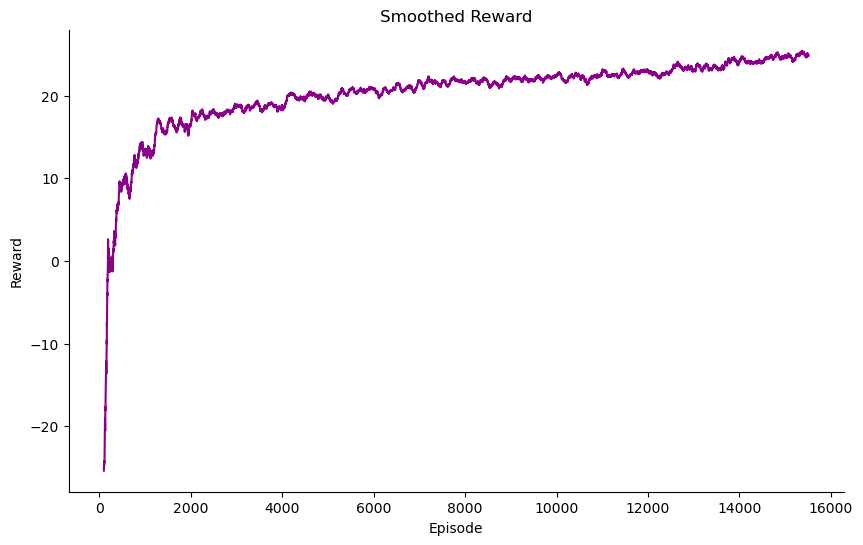

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(smoothed_rewards, color='darkmagenta')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Smoothed Reward')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

----
**Comment:**

Early in the training, the reward for the first 2000 episdoes vary a lot. This makes sense as this is when the agent is exploring the environment, updating its policy based on its observations. This can be seen by the steep improvement in reward per episode as the policy is updated and the agent starts to exploit the environemnt.

After 2000 episodes, the curve begins to flatten and the rewards start to stabalise around the 20 mark. This is a sign the agent has successfully learned the task well enough and its performance is now stable. After 8000 episodes, the agent's performance no longer improves much suggesting the agent has reached a near optimal policy.

Overall training the agent aligned with typical patterns seen from RL agents. The agent gradually shifts from exploration to exploitation with the learning curve flattening as it reaches a near-optimal policy. 

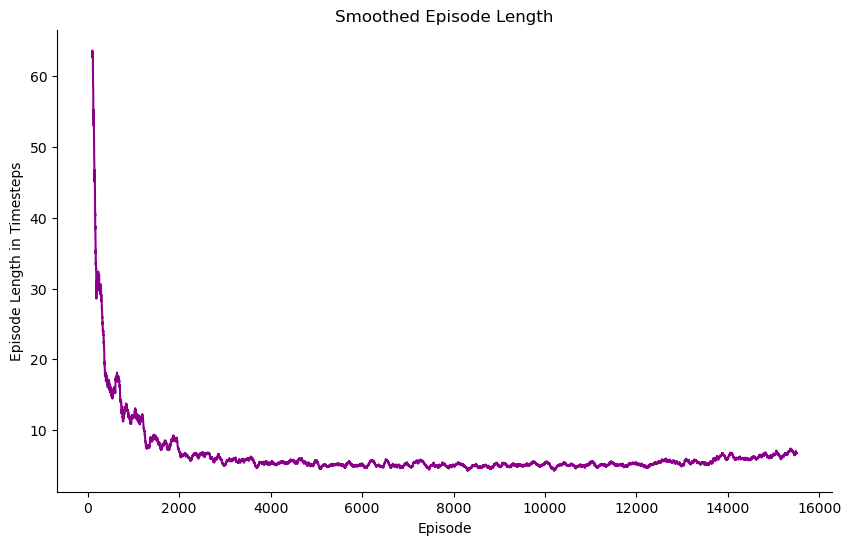

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(smoothed_length, color='darkmagenta')
plt.xlabel('Episode')
plt.ylabel('Episode Length in Timesteps')
plt.title('Smoothed Episode Length')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

-----
**Comment:**

Early in the training the agent takes a more timesteps to complete the task. This makes sense in RL as early on in the training the agent prioritises exploring its environment taking more timesteps.

As the training progresses, the agent refines its policy and begins to exploit what it has learned, leading to fewer timesteps per episode. The curve beigns to plateau around episode 4000, the agent's policy has become more effective in completing the task, This stability in timesteps suggests the agent has learned a near-optimal path.

After 14,000 episodes, there is a slight increase in timesteps. I am unsure why this could be happening, perhaps the agent has begun to overfit to the certain environment states and struggles in different states. This would be something to look into, I think I will have to do a bit more research into RL to see why this


### Saving the Model

In [30]:
model.save('../../Training/Saved Models/PPO_intm_haunted_mansion')

### Evaluation

In [43]:
from stable_baselines3.common.evaluation import evaluate_policy
evaluate_policy(model, v_env, n_eval_episodes = 10, render = False)

/Users/simybasra/anaconda3/envs/trick_or_retreat/lib/python3.9/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


(26.220000271499156, 3.3922855118394657)

----
**Comment**

**Mean Reward: 27.56**
- Average reward across all ten episodes is greater than 20.
- 20 points is given when the agent reaches the target(door), this means the agent has learned the task successfully.

**Standard Deviation: 1.57**
- Shows little variability in the agent's performance across all episodes.
- Suggests the policy the agent has is rather stable and produces consistent results.


### Testing After Training

In [26]:
# Register the environment
gym.register(
    id='Haunted_Mansion-v2',
    entry_point = '__main__:Intm_Haunted_Mansion'  
)

/Users/simybasra/anaconda3/envs/trick_or_retreat/lib/python3.9/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment Haunted_Mansion-v2 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [27]:
env = gym.make('Haunted_Mansion-v2', render_mode = 'human')

In [28]:
# Setting the number of episodes for testing
episodes = 15

for episode in range(1, episodes + 1):
   
    # Resetting the environment to an initial state
    obs, info_= env.reset()
    done = False
    score = 0
    
    while not done:
        # Get action from the trained model
        action, _ = model.predict(obs) 
        # Step through the environment using the action
        obs, reward, terminated,truncated, info = env.step(action)  
               
        # Update the done condition based on terminated flag (truncated is always False in this env)
        done = terminated

        # Visualise the environment after each action agent takes
        env.render()

        # Add reward received for action to total episode score
        score += reward
        
        # Delay to slow down the movement for better observation
        pygame.time.delay(350) 
    
    # After the episode ends, print the score
    print(f'Episode {episode} Score: {round(score,2)}')

env.close()

Episode 1 Score: 23.0
Episode 2 Score: 28.4
Episode 3 Score: 27.4
Episode 4 Score: 28.2
Episode 5 Score: 20
Episode 6 Score: 22.4
Episode 7 Score: 28.2
Episode 8 Score: 20
Episode 9 Score: 19.8
Episode 10 Score: 24.0
Episode 11 Score: 28.4
Episode 12 Score: 20
Episode 13 Score: 28.4
Episode 14 Score: 27.6
Episode 15 Score: 28.2


-----
**Comment:**

Overall the agent shows a strong performance all but one score are greater than or equal to 20. 

Training with PPO was sufficient in this instance, could be due to the relative simplicity of the environment still. All objects (rewads/penalites) in the environemnt are stable apart from the agent. I now progress to training with Q-learning to compare results. 

## Training with Q-learning
----